In [1]:
import copy

import numpy as np
from Trip import Trip
from Point import Point
from Trips import Trips
import math
import matplotlib.pyplot as plt
import gurobipy as gb
from Simulation import Simulation

# SM

In [ ]:
def sm_matheuristic(J,D,trips):
    I=range(len(trips))
    # to construct theta
    # TODO Controllare
    theta=np.zeros((len(trips),len(J)))
    for i in I:
        for j in range(len(J)):
            theta[i,j]=1 if any(obj.u == J[j].u and J[j].v for obj in trips[i].J) else 0

    C=[]
    for trip in trips:
        time_pure_taxi_trip=trip.get_pure_taxi_trip()
        trip_time_drop_off_array=trip.get_array_pure_taxi_trip_drop_off()
        realocation_move_time_array=[]

        for j in trip.J:
            time_plus_realocation=copy.deepcopy(trip_time_drop_off_array)
            for idx, pi_p in enumerate(trip.pi):
                realocation_move_time=Trip.get_travel_time_relocation_move(j,pi_p)
                time_plus_realocation[idx]+=realocation_move_time

            realocation_move_time_array.append(min(time_plus_realocation))

        time_result=max(time_pure_taxi_trip,max(realocation_move_time_array))
        C.append(time_result)

    sm_mip = gb.Model()
    sm_mip.modelSense = gb.GRB.MINIMIZE #declare mimization
    Y = sm_mip.addVars( [i for i in I], vtype=gb.GRB.BINARY)
    for j in range(len(J)):
        sm_mip.addConstr( gb.quicksum(Y[i]*theta[i,j] for i in I) >= 1 )

    sm_mip.setObjective(gb.quicksum( Y[i]*C[i]  for i in I))
    sm_mip.optimize()
    print( "\n", type(Y), Y, "\n")
    print("\nSolution")

    for i in I:
        print(f'Y[{i}]= {Y[i].x}')

In [ ]:
def trptr_problem(drop_off_points,n,m):
    K=range(1,int(np.ceil(n/(np.ceil((m+1)/2))))+1)
    R=range(1,m+1)
    J= range(1,n+1)
    D=range(len(drop_off_points))
    #d=[]
    #delta=[]
    central_depot_s=0
    central_depot_e=central_depot_s
    M=1000
    trptr_mip = gb.Model()
    trptr_mip.modelSense = gb.GRB.MINIMIZE
    # Variables
    t = trptr_mip.addVars( [(k,i) for k in K for i in D],lb=0, vtype=gb.GRB.CONTINUOUS)
    C = trptr_mip.addVars( [k for k in K],lb=0, vtype=gb.GRB.CONTINUOUS)
    S = trptr_mip.addVars( [(k,i,p) for k in K for i in D for p in R], vtype=gb.GRB.BINARY)
    Y = trptr_mip.addVars( [(j,i) for j in J for i in D], vtype=gb.GRB.BINARY)
    X = trptr_mip.addVars( [(k,j) for k in K for j in J], vtype=gb.GRB.BINARY)

    # Contraints
    #X(k,j)=1
    for j in J:
        trptr_mip.addConstr( gb.quicksum(X[k,j] for k in K) == 1 )
    # Y(j,i)=1
    for j in J:
        trptr_mip.addConstr( gb.quicksum(Y[j,i] for i in D) == 1 )

    for k in K:
        trptr_mip.addConstr( gb.quicksum(X[k,j] for j in J) <= m)

    for k in K:
        for j in J:
            for i in D:
                 trptr_mip.addConstr(X[k,j]+Y[j,i]<=1+ gb.quicksum(S[k,i,p] for p in R))

    for k in K:
        for p in R:
            trptr_mip.addConstr(gb.quicksum(S[k,i,p] for i in D)<=1)

    for k in K:
        for i in D:
            trptr_mip.addConstr(gb.quicksum(S[k,i,p] for p in R)<=1)

    for k in K:
        for p in [x for x in R if x != 1]:
            trptr_mip.addConstr(gb.quicksum(S[k,i,p] for i in D)<=gb.quicksum(S[k,i,p-1] for i in D))

    # t's constraints
    for k in K:
        for i in D:
            #trptr_mip.addConstr(t[k,i]>=S[k,i,1]*delta[central_depot_s,i])
            trptr_mip.addConstr(t[k,i]>=S[k,i,1]*Trip.get_travel_time_drop_off(central_depot_s,i))

    for k in K:
        for i1 in D:
            for i2 in [x for x in D if x != i1]: # D\{i1}
                for p in [x for x in R if x != 1]:
                    #trptr_mip.addConstr(t[k,i2]>=t[k,i1]-M*(2-S[k,i1,p-1]-S[k,i2,p])+delta[i1,i2])
                    trptr_mip.addConstr(t[k,i2]>=t[k,i1]-M*(2-S[k,i1,p-1]-S[k,i2,p])+ Trip.get_travel_time_drop_off(i1,i2))

    # C's constraints
    for k in K:
        for j in J:
            for i in D:
                #trptr_mip.addConstr(C[k]>=t[k,i]-M*(2-X[k,j]-Y[j,i])+d[j,i])
                trptr_mip.addConstr(C[k]>=t[k,i]-M*(2-X[k,j]-Y[j,i])+Trip.get_travel_time_relocation_move(j,i))

    for k in K:
        for i in D:
            #trptr_mip.addConstr(C[k]>=t[k,i]-M*(1-gb.quicksum(S[k,i,p] for p in R))+delta[i,central_depot_e])
            trptr_mip.addConstr(C[k]>=t[k,i]-M*(1-gb.quicksum(S[k,i,p] for p in R))+ Trip.get_travel_time_drop_off(i,central_depot_e))

    for k in [x for x in K if x != 1]:
        trptr_mip.addConstr(C[k]<=C[k-1])

    # Objective function
    trptr_mip.setObjective(gb.quicksum(C[k]  for k in K))
    # Solution
    trptr_mip.optimize()
    print( "\n", type(X), X, "\n")
    print( "\n", type(Y), Y, "\n")
    print( "\n", type(S), S, "\n")
    print("\nSolution")



In [3]:
n,m,ks,kr,kn,T_start,c=Simulation.get_simulation_number(0)

In [4]:

J,D=Simulation.initialize_map(n)


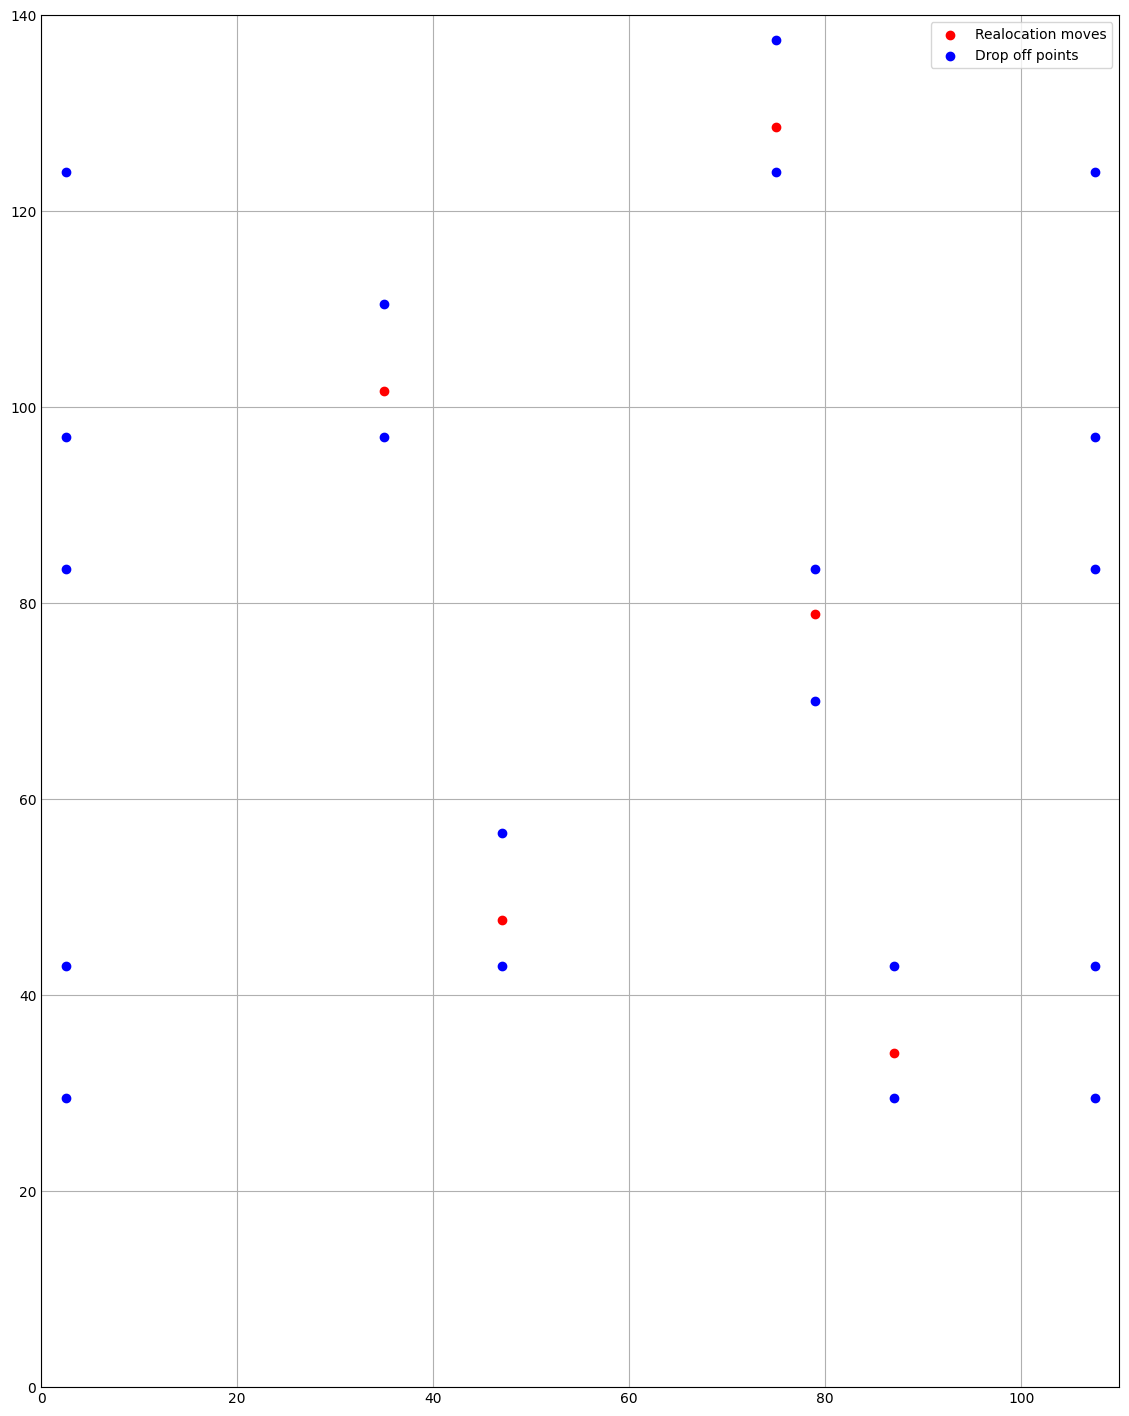

In [5]:
Simulation.plot_map(J,D,[])


In [ ]:
trips=sa_approach(n,m,5,5,5,T_start,c,J,D)


0
[<Trip.Trip object at 0x11665ff10>, <Trip.Trip object at 0x11665fe80>]
[<Trip.Trip object at 0x11665ff10>, <Trip.Trip object at 0x11665fe80>]
